# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
import torch
from torchvision import datasets, transforms

# Load your dataset (e.g., CIFAR10)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True,
                                 transform=transforms.ToTensor())

# Calculate the mean and standard deviation
mean = 0.0
std = 0.0
num_samples = len(train_dataset)

for images, labels in train_dataset:
    # Calculate mean and std for each image
    mean += images.mean(dim=(1, 2))
    std += images.std(dim=(1, 2))

# Average across all images
mean /= num_samples
std /= num_samples
print('mean = ', mean)
print('std deviation = ', std)


# Create a Normalize transform
normalize = transforms.Normalize(mean=mean, std=std)

# Apply the transform to your DataLoader
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         normalize
                     ])),
    batch_size=64, shuffle=True)

Files already downloaded and verified
mean =  tensor([0.4914, 0.4822, 0.4465])
std deviation =  tensor([0.2023, 0.1994, 0.2010])
Files already downloaded and verified


In [20]:
#data_dir = '~/.pytorch/CIFAR10/'
from torch.utils.data import random_split


# Define transforms
## YOUR CODE HERE ##

train_transforms = transforms.Compose([transforms.Resize(32),
                                      transforms.RandomRotation(15),
                                      transforms.RandomCrop(32, padding = 4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2203, 0.1994, 0.2010))]) #normalization for RGB images

test_transforms = transforms.Compose([transforms.Resize(32),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) #normalization for RGB images



# Create training set and define training dataloader
## YOUR CODE HERE ##
full_train_data = datasets.CIFAR10(root='./data', train = True, download = True, transform=train_transforms)
train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
training_data, validation_data = random_split(full_train_data, [train_size, val_size])
test_data = datasets.CIFAR10(root='./data', train = False, download = True, transform=test_transforms)

# Create test set and define test dataloader
## YOUR CODE HERE ##
trainloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [27]:
num_samples = len(full_train_data)

# Get the shape of a single image (CIFAR-10 images are 32x32 with 3 color channels)
image, label = full_train_data[0]
image_shape = image.shape

# Print the results
print(f"Number of training samples: {num_samples}")
print(f"Number of test samples: {len(test_data)}")
print(f"Shape of a single image: {image_shape}")
print('len trainloader ', len(trainloader))
print('len test ', len(testloader))

def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Number of training samples: 50000
Number of test samples: 10000
Shape of a single image: torch.Size([3, 32, 32])
len trainloader  625
len test  157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


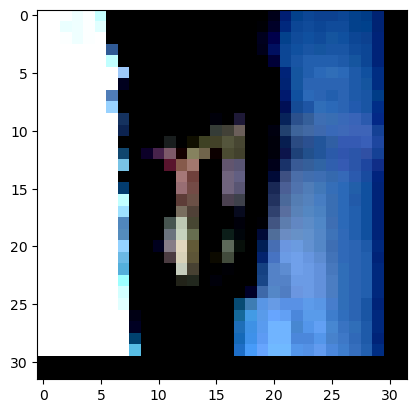

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


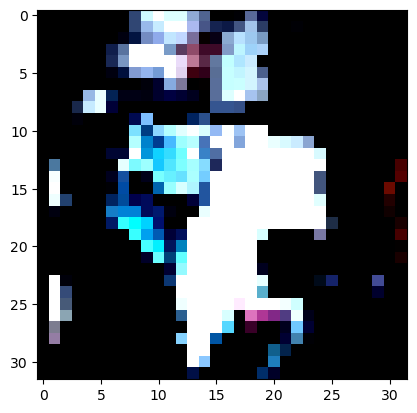

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


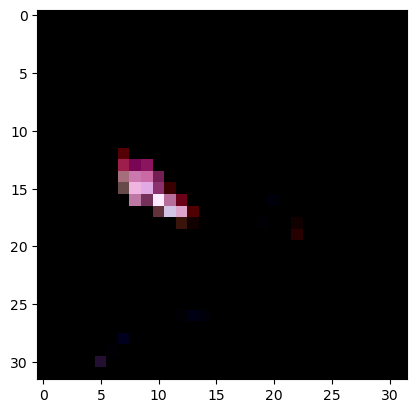

ship


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


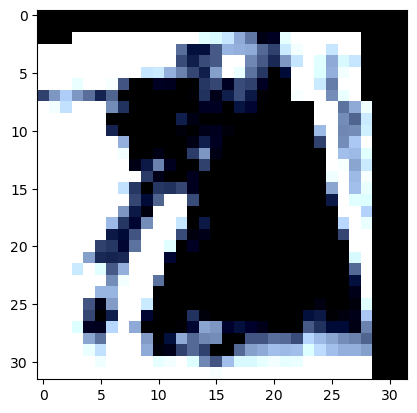

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


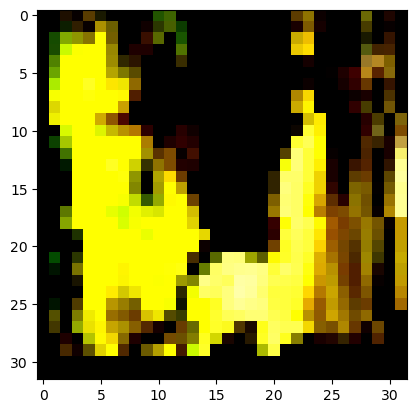

In [29]:
# Explore data
## YOUR CODE HERE ##

show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [41]:
## YOUR CODE HERE ##

model = torch.nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
                            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
                            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512 , 10))


In [51]:
print('Do we have NVIDIA CUDA acceleration?', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print (device)
torch.cuda.empty_cache()


import subprocess

def get_gpu_info():
    try:
        # Run the `nvidia-smi` command and capture its output
        result = subprocess.run(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'],
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        
        # Check if the command was successful
        if result.returncode == 0:
            gpu_name = result.stdout.strip()  # Get the name of the GPU
            return gpu_name
        else:	
            return "No NVIDIA GPU found or `nvidia-smi` not available."
    except FileNotFoundError:
        return "nvidia-smi not found. Please ensure you have the NVIDIA drivers installed."

# Example usage:
gpu_name = get_gpu_info()
print(f"Your NVIDIA GPU: {gpu_name}")

Do we have NVIDIA CUDA acceleration? True
cuda
Your NVIDIA GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [53]:
## YOUR CODE HERE ##

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
#optimizer = optim.Adagrad(model.parameters(), lr=0.01)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [55]:
## YOUR CODE HERE ##
num_epochs = 30
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    running_loss = 0
    start_time = time.time()
    for images, labels in trainloader:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        end_time = time.time()
        print(f'Time to train Epoch {epoch+1}/{num_epochs} on {device}: {(end_time-start_time):.2f} seconds')
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels).item()
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        finish_time = time.time()
        print(f'Time to evaluate Epoch {epoch+1}/{num_epochs} on {device}: {(finish_time - end_time):.2f} seconds')
        
        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Average Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Average Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Average Test Accuracy: {:.3f}".format(100*accuracy/len(testloader)))


Time to train Epoch 1/30 on cuda: 101.40 seconds
Time to evaluate Epoch 1/30 on cuda: 13.18 seconds
Epoch: 1/30..  Average Training Loss: 1.886..  Average Test Loss: 1.787..  Average Test Accuracy: 32.484
Time to train Epoch 2/30 on cuda: 101.99 seconds
Time to evaluate Epoch 2/30 on cuda: 13.56 seconds
Epoch: 2/30..  Average Training Loss: 1.776..  Average Test Loss: 1.673..  Average Test Accuracy: 37.629
Time to train Epoch 3/30 on cuda: 101.19 seconds
Time to evaluate Epoch 3/30 on cuda: 13.48 seconds
Epoch: 3/30..  Average Training Loss: 1.686..  Average Test Loss: 1.643..  Average Test Accuracy: 42.844
Time to train Epoch 4/30 on cuda: 104.26 seconds
Time to evaluate Epoch 4/30 on cuda: 12.47 seconds
Epoch: 4/30..  Average Training Loss: 1.584..  Average Test Loss: 1.479..  Average Test Accuracy: 49.851
Time to train Epoch 5/30 on cuda: 97.47 seconds
Time to evaluate Epoch 5/30 on cuda: 12.25 seconds
Epoch: 5/30..  Average Training Loss: 1.450..  Average Test Loss: 1.337..  Averag

Plot the training loss (and validation loss/accuracy, if recorded).

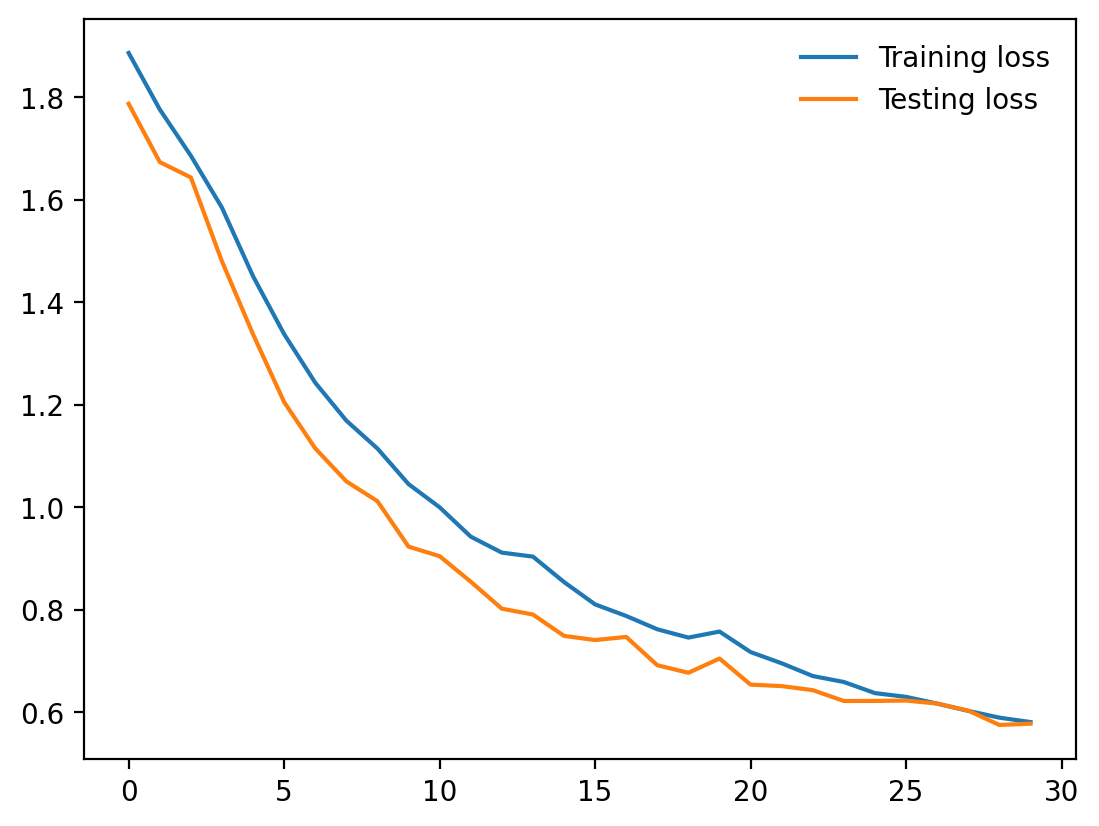

In [57]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [59]:
## TEST YOUR MODEL HERE ##

#dataiter = iter(testloader)
#images, labels = next(dataiter)
model.eval()
correct = 0
total = 0

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in testloader:  # Assuming test_loader is your DataLoader for the test set
        # Move images and labels to the appropriate device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        ps = torch.exp(outputs)
        top_probs, top_class = ps.topk(1, dim=1)  # dim=1 to get top k for each row (each image)
        #equals = top_class == labels.view(*top_class.shape)
        top_class = top_class.view(1, -1)
        
        total += labels.size(0)  # Update total number of samples
        correct += (top_class.view(1, -1) == labels).sum().item()  # Count correct predictions
        #print('top_class shape:',top_class.shape)
        #print('labels shape', labels.shape)
    
       # print ('top_class \n', top_class)
        #print('labels\n', labels)

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Accuracy of the model on the test set: 84.40%


## Saving your model
Using `torch.save`, save your model for future loading.

In [61]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'modelCIFAR10.pth')


## Plotting some predictions! 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


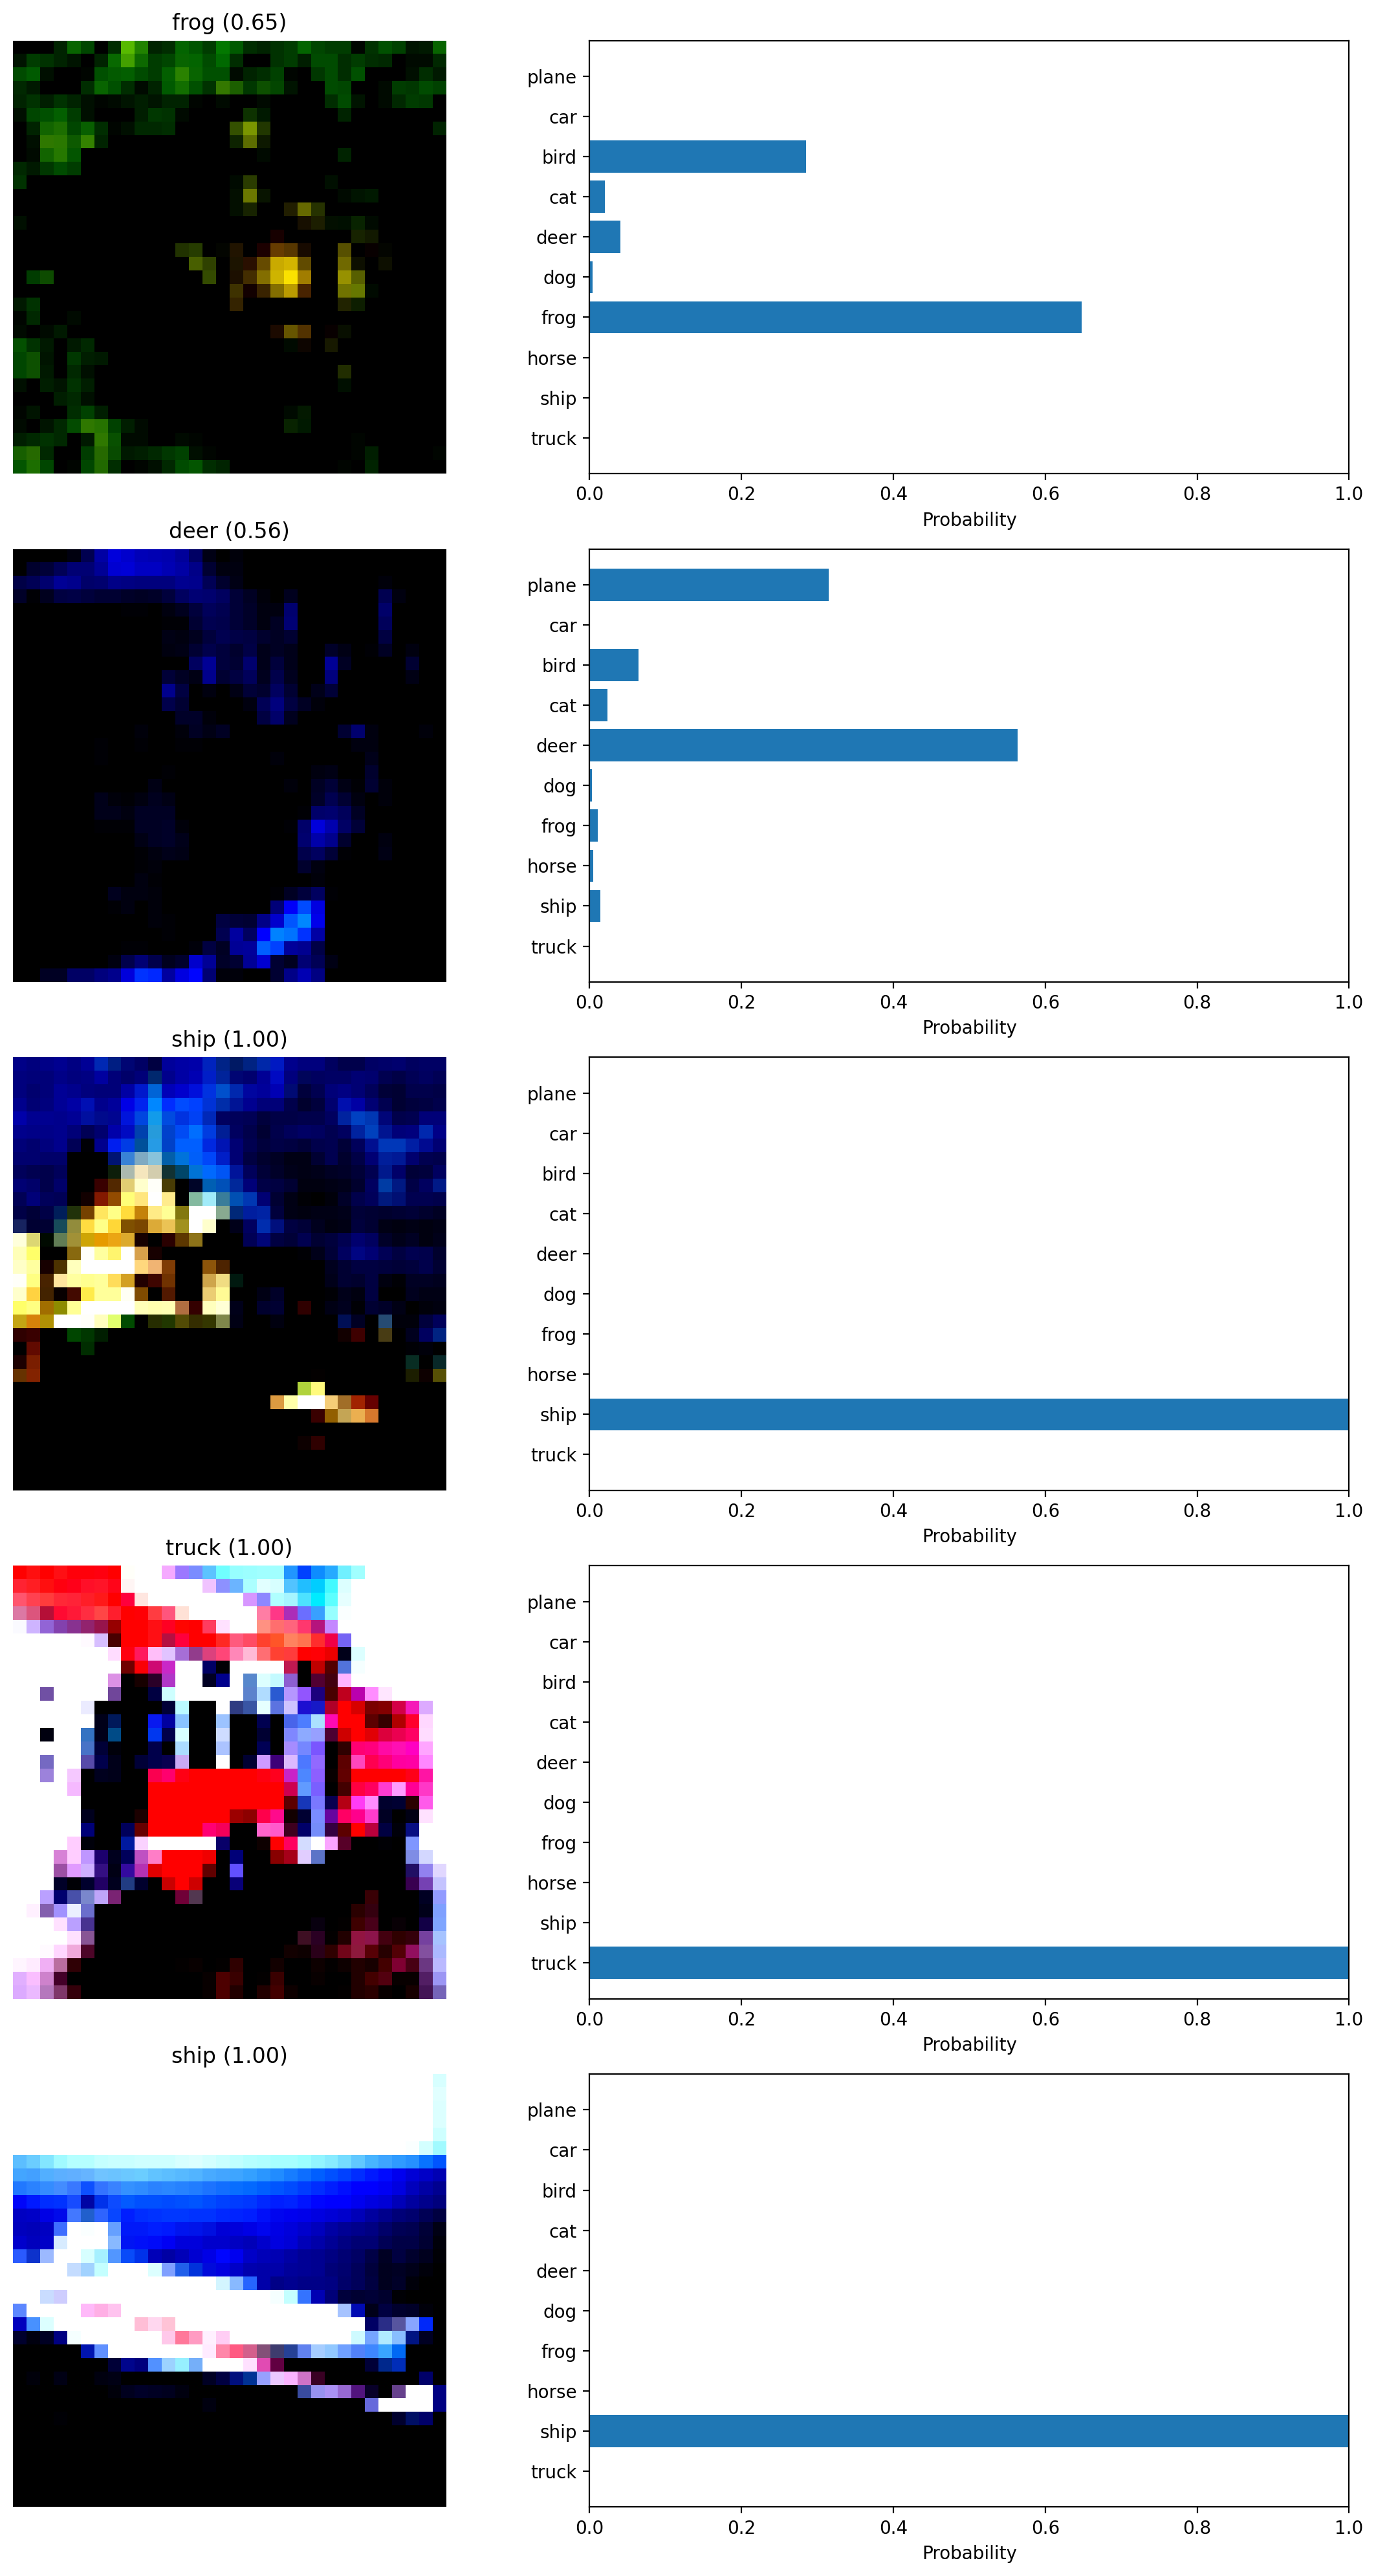

In [63]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch
import matplotlib.pyplot as plt

# Check if CUDA is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to get a random batch of images from the loader
def get_random_batch(loader):
    """ Get a random batch of images from the loader """
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Move images and labels to the GPU
    return images.to(device), labels.to(device)

# Get a random batch from the test loader
images, labels = get_random_batch(testloader)

# Select 5 random images from the batch
indices = torch.randperm(images.size(0))[:5]  # Randomly select 5 indices
random_images = images[indices]
random_labels = labels[indices]

# Calculate the class probabilities (softmax) for the selected images
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(random_images)

# Convert output logits to probabilities
probs = torch.softmax(outputs, dim=1).cpu()

def view_classify(imgs, probs, classes):
    ''' Function for viewing 5 images, their predicted classes, and the probability chart.
    '''
    fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows, 2 columns for images and charts
    
    for idx in range(5):
        img = imgs[idx].cpu().numpy().transpose((1, 2, 0))
        prob = probs[idx].numpy()

        # Display image
        axes[idx, 0].imshow(img)
        axes[idx, 0].axis('off')
        
        # Get the class with the highest probability
        pred_class = classes[prob.argmax()]
        prob_str = f"{pred_class} ({prob.max():.2f})"
        axes[idx, 0].set_title(prob_str)

        # Display the probability chart
        axes[idx, 1].barh(np.arange(10), prob)
        axes[idx, 1].set_yticks(np.arange(10))
        axes[idx, 1].set_yticklabels(classes)
        axes[idx, 1].set_xlim(0, 1)
        axes[idx, 1].set_xlabel('Probability')
        axes[idx, 1].invert_yaxis()  # Highest probability at the top

    plt.tight_layout()

# Define CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the 5 randomly selected images and their predicted classes with probability charts
view_classify(random_images, probs, classes)


## Make a Recommendation

Using a linear model with fully connected layers I obtained a max 50% accuracy. 
I tried changing the learninr rate, the dropout probabilities, the optimizer, the number of layers but nothing improved the accuracy. 
Only when I added convoluational netowrk layers I was able to obtain 88% accuracy. 
The images do not look right when i plot them no matter what I try. 
I think The transformations mess them up.   

So my recomandation is not to buy the model because we can do much better in house.
Note: I do not see the point in sacrificing 10-20% of the training set for validation. 
Is like having a double testing and we already have a testing set. 


### **Double click this cell to modify it**

